<a href="https://colab.research.google.com/github/Anjasfedo/Learning-TensorFlow/blob/main/eat_tensorflow2_in_30_days/Chapter3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-1 Low-level API: Demonstration

The examples below use low-level APIs in TensorFlow to implement a linear regression model and a DNN binary classification model.

Low-level API includes tensor operation, graph, and automatic differentiates

In [184]:
import tensorflow as tf

# Time Stamp
@tf.function
def printbar():
  today_ts = tf.timestamp()%(24*60*60)

  hour = tf.cast(today_ts//3600+8, tf.int32)%tf.constant(24)
  minute = tf.cast((today_ts%3600)//60, tf.int32)
  second = tf.cast(tf.floor(today_ts%60), tf.int32)

  def timeformat(m):
    if tf.strings.length(tf.strings.format('{}', m)) == 1:
      return (tf.strings.format('0{}', m))
    else:
      return (tf.strings.format('{}', m))

  timestring = tf.strings.join([timeformat(hour),timeformat(minute),
                timeformat(second)],separator = ":")
  tf.print("=========="*8+timestring)

## 1. Linear Regression Model

### (a) Data preparation

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [186]:
# Number of samples
n = 400

In [187]:
# Generate dataset
X = tf.random.uniform([n, 2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2.0) # @ is matrix multiplication; adding Gaussian noise

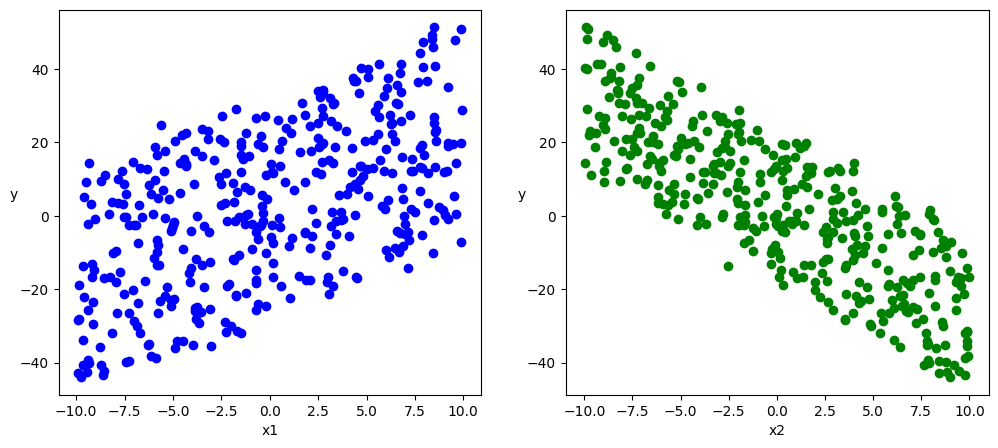

In [188]:
# Data Visualization

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c='b')
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c='g')
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()

In [189]:
# Create generator of data pipeline
def data_iter(features, labels, batch_size=8):
  num_examples = len(features)
  indices = list(range(num_examples))
  np.random.shuffle(indices) # randomized rading order of the samples

  for i in range(0, num_examples, batch_size):
    indexs = indices[i: min(i + batch_size, num_examples)]
    yield tf.gather(features, indexs), tf.gather(labels, indexs)

# Testing the data pipeline
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 7.882841   3.1859732]
 [ 2.9995584  9.412052 ]
 [ 8.534603  -1.9746132]
 [ 8.560902   1.8312788]
 [-9.885044   3.5591078]
 [ 2.1515446 -2.4282575]
 [ 9.86829   -9.818764 ]
 [-5.5152607 -5.605409 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 13.167465]
 [-16.720497]
 [ 22.980886]
 [ 13.218194]
 [-28.26146 ]
 [ 17.651464]
 [ 50.919014]
 [  7.110356]], shape=(8, 1), dtype=float32)


### (b) Model Definition

In [190]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

# Defining Model
class LinearRegression:
  # Forward propagation
  def __call__(self,x):
    return x@w + b

  # Loss function
  def loss_func(self,y_true,y_pred):
    return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()

### (c) Model Training

In [191]:
# Debug in dynamic graph
def train_step(model, features, labels):
  with tf.GradientTape() as tape:
    predictions = model(features)
    loss = model.loss_func(labels, predictions)

  # Back propagation to calculate the gradient
  dloss_dw, dloss_db = tape.gradient(loss,[w,b])

  # Updating parameters using gradient descending method
  w.assign(w - 0.001*dloss_dw)
  b.assign(b - 0.001*dloss_db)

  return loss

In [192]:
# Test the results of train_step
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=73.87663>

In [193]:
def train_model(model,epochs):
  for epoch in tf.range(1,epochs+1):
      for features, labels in data_iter(X,Y,10):
          loss = train_step(model,features,labels)

      if epoch%50==0:
          printbar()
          tf.print("epoch =",epoch,"loss = ",loss)
          tf.print("w =",w)
          tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================21:40:04
epoch = 50 loss =  1.37025511
w = [[2.02683139]
 [-2.99464846]]
b = [[2.45024753]]
================================================================================21:40:13
epoch = 100 loss =  2.08350754
w = [[2.0204432]
 [-2.99646688]]
b = [[2.77954721]]
================================================================================21:40:23
epoch = 150 loss =  1.55811095
w = [[2.03255463]
 [-2.99843383]]
b = [[2.82497668]]
================================================================================21:40:33
epoch = 200 loss =  3.37472844
w = [[2.01579952]
 [-2.98444748]]
b = [[2.82986212]]


In [194]:
# Accelerate using Autograph to transform the dynamic graph into static

@tf.function
def train_step(model, features, labels):
  with tf.GradientTape() as tape:
    y_pred = model(features)
    loss = model.loss_func(labels, y_pred)

  # Back propagation to calculate the gradients
  dloss_dw, dloss_db = tape.gradient(loss, [w, b])

  # Updating parameters using gradient descending method
  w.assign(w - 0.001 * dloss_dw)
  b.assign(b - 0.001 * dloss_db)

  return loss

def train_model(model, epochs):
  for epoch in tf.range(1, epochs + 1):
    for features, labels in data_iter(X, Y, 10):
      loss = train_step(model, features, labels)

    if epoch % 50 == 0:
      printbar()
      tf.print("epoch =",epoch,"loss = ",loss)
      tf.print("w =",w)
      tf.print("b =",b)

train_model(model, epochs = 200)

================================================================================21:40:36
epoch = 50 loss =  1.40756261
w = [[2.0195148]
 [-2.98676443]]
b = [[2.83118796]]
================================================================================21:40:39
epoch = 100 loss =  2.2031014
w = [[2.03305173]
 [-2.98681664]]
b = [[2.83039761]]
================================================================================21:40:42
epoch = 150 loss =  3.12157655
w = [[2.01794219]
 [-3.00469708]]
b = [[2.831213]]
================================================================================21:40:45
epoch = 200 loss =  3.48862529
w = [[2.03023911]
 [-2.99599075]]
b = [[2.83159089]]


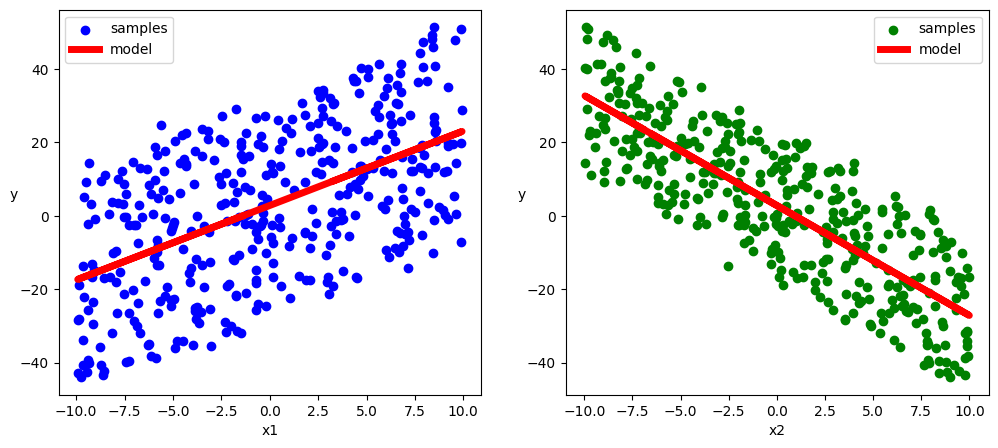

In [195]:
# Visualize the results

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c="b", label="samples")
ax1.plot(X[:, 0], w[0]*X[:, 0] + b[0], "-r", linewidth=5.0, label="model")
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c="g", label="samples")
ax2.plot(X[:, 1], w[1]*X[:, 1] + b[0], "-r", linewidth=5.0, label="model")
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)

plt.show()

## 2. DNN Binary Classification Model

### (a) Data Preparation

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [266]:
# Number of positive & negative samples
n_positive, n_negative = 2000, 2000

In [267]:
# Generating the positive samples with a distribution on a smaller ring
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0, 2*np.pi)

Xp = tf.concat([r_p * tf.cos(theta_p), r_p * tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

In [268]:
# Generating the negative samples with distribuion on a larger ring
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0.0, 2*np.pi)

Xn = tf.concat([r_n * tf.cos(theta_n), r_n * tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

In [269]:
# Assembling all samples
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

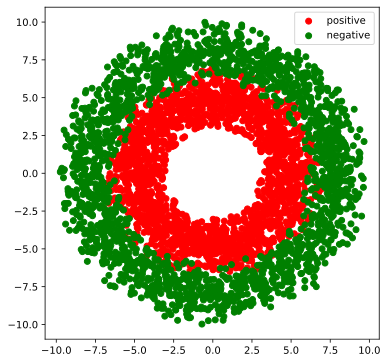

In [270]:
# Visualize the data
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r', label='positive')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g', label='negative')
plt.legend()
plt.show()

In [271]:
# Create the data generator of the data pipeline
def data_iter(features, labels, batch_size=8):
  num_examples = len(features)
  indices = list(range(num_examples))

  np.random.shuffle(indices)

  for i in range(0, num_examples, batch_size):
    indexs = indices[i: min(i + batch_size, num_examples)]
    yield tf.gather(features,indexs), tf.gather(labels,indexs)

# Testing data pipeline
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)

tf.Tensor(
[[-5.670064  -7.201375 ]
 [-6.1059437 -3.150574 ]
 [-5.9937034  4.4155545]
 [-2.868903   6.983433 ]
 [-6.417581   4.2088   ]
 [-7.769907   2.321114 ]
 [-1.9846066 -3.3981884]
 [-5.3030214 -6.9847374]
 [ 1.0638838 -5.136163 ]
 [ 5.56598    7.481956 ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(10, 1), dtype=float32)


### (b) Model Definition

Here the `tf.Module` is used for organizing the parameter in the model.

In [272]:
class DNNModel(tf.Module):
  def __init__(self, name=None):
    super(DNNModel, self).__init__(name=name)
    self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
    self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
    self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
    self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
    self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
    self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

  # Forward propagation
  @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
  def __call__(self, x):
    x = tf.nn.relu(x@self.w1 + self.b1)
    x = tf.nn.relu(x@self.w2 + self.b2)
    y = tf.nn.sigmoid(x@self.w3 + self.b3)
    return y

  # Loss function (binary cross entropy)
  @tf.function(input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
                                tf.TensorSpec(shape=[None, 1], dtype=tf.float32)])
  def loss_func(self, y_true, y_pred):
    # Limit the prediction between 1e-7 and 1 - 1e-7 to avoid the error at log(0)
    eps = 1e-7
    y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
    bce = - y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    return tf.reduce_mean(bce)

  # Metric (Accuracy)
  tf.function(input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32),
                                tf.TensorSpec(shape=[None, 1], dtype=tf.float32)])
  def metric_func(self, y_true, y_pred):
    y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred, dtype=tf.float32), tf.zeros_like(y_pred, dtype=tf.float32))
    acc = tf.reduce_mean(1 - tf.abs(y_true - y_pred))
    return acc

model = DNNModel()

In [273]:
# Testing the structure of model
batch_size = 10
(features, labels) = next(data_iter(X, Y, batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 6.50522089
init metric 0.2


In [274]:
print(len(model.trainable_variables))

6


### (c) Model Training

In [275]:
# Transform to static graph for acceleration using Autograph

@tf.function
def train_step(model, features, labels):
  with tf.GradientTape() as tape:
    predictions = model(features)
    loss = model.loss_func(labels, predictions)

  # Backward propagation to calculate the gradients
  grads = tape.gradient(loss, model.trainable_variables)

  # Applying gradient descending
  for p, dloss_dp in zip(model.trainable_variables, grads):
    p.assign(p - 0.001 * dloss_dp)

  # Calculate metric
  metric = model.metric_func(labels, predictions)

  return loss, metric

def train_model(model, epochs):
  for epoch in tf.range(1, epochs + 1):
    for features, labels in data_iter(X, Y, 100):
      loss, metric = train_step(model, features, labels)

    if epoch % 100 == 0:
      printbar()
      tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)

train_model(model, epochs=600)

================================================================================22:40:42
epoch = 100 loss =  0.608321488 accuracy =  0.57
================================================================================22:40:50
epoch = 200 loss =  0.537293911 accuracy =  0.81
================================================================================22:40:56
epoch = 300 loss =  0.448983431 accuracy =  0.86
================================================================================22:41:04
epoch = 400 loss =  0.37082389 accuracy =  0.9
================================================================================22:41:11
epoch = 500 loss =  0.284836948 accuracy =  0.96
================================================================================22:41:22
epoch = 600 loss =  0.23090367 accuracy =  0.97


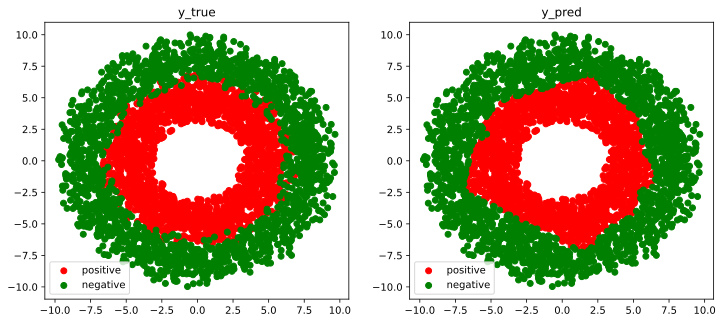

In [277]:
# Visualizing the results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax1.scatter(Xp[:, 0], Xp[:, 1], c='r')
ax1.scatter(Xn[:, 0], Xn[:, 1], c='g')
ax1.legend(['positive', 'negative'])
ax1.set_title('y_true')

Xp_pred = tf.boolean_mask(X, tf.squeeze(model(X) >= 0.5), axis=0)
Xn_pred = tf.boolean_mask(X, tf.squeeze(model(X) < 0.5), axis=0)

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c='r')
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c='g')
ax2.legend(['positive', 'negative'])
ax2.set_title('y_pred')

plt.show()